In [6]:
import re
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path().resolve().parent / "src"))
from daphnet_utils import do_plot, x_fi, do_test, x_numerical_integration, x_count_transitions, load_full_dataset

In [7]:
print("Current working directory:", Path.cwd())

root_dir = Path.cwd().parent
file_path = root_dir / "data" / "daphnet_freezing_of_gait" / "dataset_fog_release" / "dataset"

Current working directory: /app/notebooks


(151987, 11)
label
1    87655
0    59185
2     5147
Name: count, dtype: int64


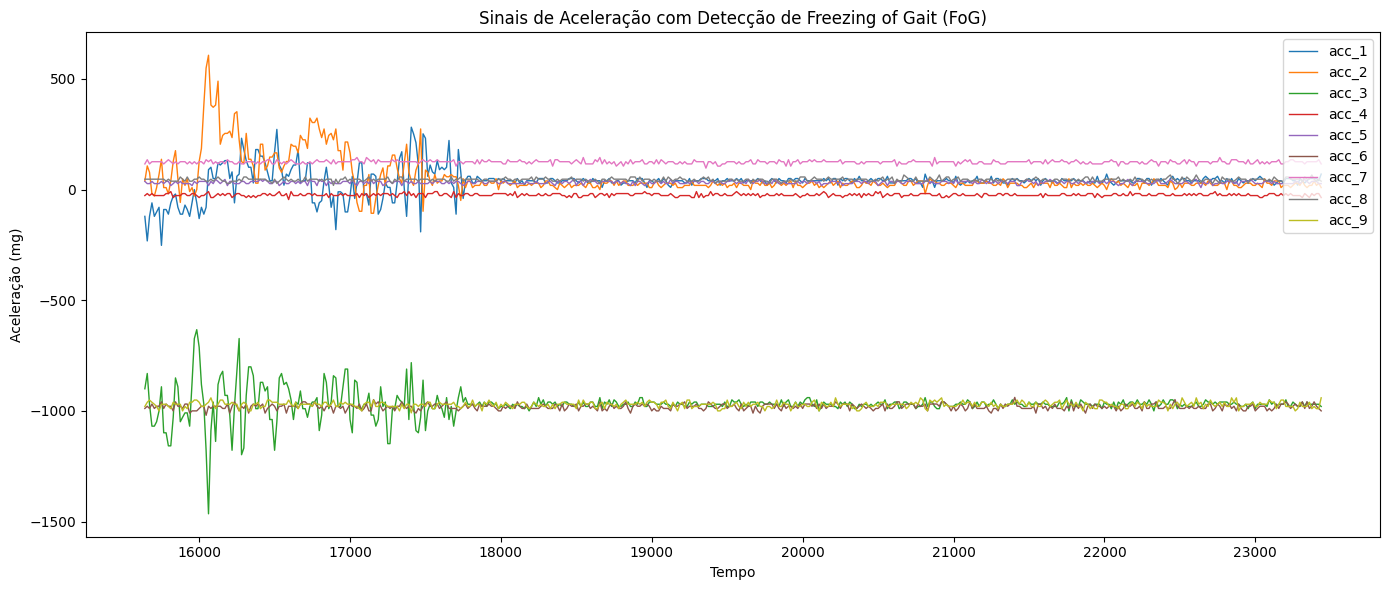

In [8]:
def load_daphnet_file(path):
    """
    Lê um arquivo do dataset Daphnet Freezing of Gait (.txt) e retorna um DataFrame formatado.

    Parameters:
    - path (str or Path): caminho para o arquivo

    Returns:
    - pd.DataFrame com colunas: time, acc_1..acc_9, label
    """
    df = pd.read_csv(path, sep=r"\s+", engine="python", header=None)
    df.columns = ["time"] + [f"acc_{i}" for i in range(1, 10)] + ["label"]
    return df

df = load_daphnet_file(file_path / "S01R01.txt")

print(df.shape)
print(df["label"].value_counts())

do_plot(df.iloc[1000:1500, 1:10].values, df.iloc[1000:1500]["label"].values, time=df.iloc[1000:1500]["time"].values)

In [9]:
from scipy.signal import welch

def compute_freeze_index(signal, fs=64, window_size=4, step_size=0.5, freeze_th=3, power_th=0.1):
    """
    Aplica o algoritmo de detecção de FOG baseado no Freeze Index.

    Parâmetros:
        signal (np.array): sinal de aceleração (1D)
        fs (int): taxa de amostragem (Hz)
        window_size (float): tamanho da janela em segundos
        step_size (float): passo da janela em segundos
        freeze_th (float): limiar do Freeze Index
        power_th (float): limiar de energia total do sinal

    Retorna:
        detections (list): lista de tuplas (início, fim, FI_médio) dos episódios detectados
        fi_series (np.array): série temporal do FI calculado
    """
    window_samples = int(window_size * fs)
    step_samples = int(step_size * fs)
    n_windows = (len(signal) - window_samples) // step_samples

    detections = []
    fi_series = []

    for i in range(n_windows):
        start = i * step_samples
        end = start + window_samples
        window = signal[start:end]

        # Welch PSD
        f, Pxx = welch(window, fs=fs, nperseg=256)

        # Potência nas bandas
        locomotor_power = np.sum(Pxx[(f >= 0.5) & (f < 3)])
        freeze_power = np.sum(Pxx[(f >= 3) & (f < 8)])
        total_power = np.sum(Pxx)

        # Freeze Index
        fi = freeze_power / (locomotor_power + 1e-8)  # Evita divisão por zero
        fi_series.append(fi)

        if total_power > power_th and fi > freeze_th:
            detections.append((start / fs, end / fs, fi))

    return detections, np.array(fi_series)


In [19]:
df_valid.head(20)

,time,acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,label
47999,0.000,-30,990,326,-45,972,181,-38,1000,29,1
48000,0.015,-30,1000,356,-18,981,212,-48,1028,29,1
48001,0.031,-20,990,336,18,981,222,-38,1038,9,1
48002,0.046,-20,1000,316,36,990,222,-19,1038,9,1
48003,0.062,0,990,316,36,990,212,-29,1038,29,1
48004,0.078,-20,1009,297,27,981,202,-9,1057,9,1
48005,0.093,-10,990,346,27,1000,202,0,1038,19,1
48006,0.109,-40,990,316,-18,990,171,29,1038,19,1
48007,0.125,-40,1009,297,-90,972,151,9,1009,29,1
48008,0.140,-50,1000,316,-90,972,151,29,1000,9,1


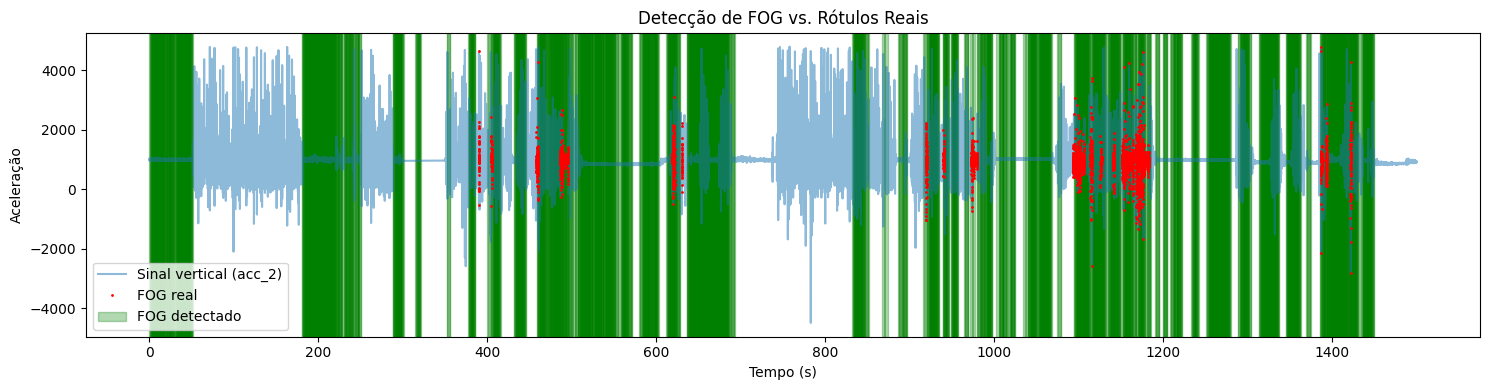

In [18]:
# Remove os trechos onde não há atividade (label == 0)
df_valid = df[df["label"] != 0].copy()
df_valid["time"] = df_valid["time"] / 1000

# Reindexa o tempo para começar do zero, se quiser
df_valid["time"] -= df_valid["time"].iloc[0]

# Atualiza o sinal de entrada
signal = df_valid["acc_2"].values

detections, fi_series = compute_freeze_index(
    signal,
    fs=64,
    window_size=4,
    step_size=0.5,
    freeze_th=3,
    power_th=0.1
)

plt.figure(figsize=(15, 4))
plt.plot(df_valid["time"], signal, label="Sinal vertical (acc_2)", alpha=0.5)

# Marcar rótulos reais de FOG
fog_regions = df_valid["label"] > 1
plt.plot(df_valid["time"][fog_regions], signal[fog_regions], '.', label="FOG real", color="red", markersize=2)

# Marcar detecções do algoritmo
for i, (start, end, fi) in enumerate(detections):
    label = "FOG detectado" if i == 0 else None
    plt.axvspan(start, end, color="green", alpha=0.3, label=label)

plt.title("Detecção de FOG vs. Rótulos Reais")
plt.xlabel("Tempo (s)")
plt.ylabel("Aceleração")
plt.legend()
plt.tight_layout()
plt.show()



In [4]:
X, y = load_full_dataset(file_path)

print("Shape do X:", X.shape)
print("Distribuição de classes:", np.bincount(y))

Shape do X: (29940, 36)
Distribuição de classes: [28207  1733]


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
def print_model_report(model, X_test, y_test, y_pred, name="Modelo"):
    print(f"\n📊 Resultado: {name}")
    print("-" * 40)

    report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print("\n🔍 Classification Report:")
    display(report_df.round(3))

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Real: 0 (Sem FoG)", "Real: 1 (FoG)"],
        columns=["Pred: 0", "Pred: 1"]
    )

    print("\n🧮 Confusion Matrix:")
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


🔍 Logistic Regression
Acurácia: 83.47%

📊 Resultado: Logistic Regression
----------------------------------------

🔍 Classification Report:


,precision,recall,f1-score,support
0,0.993,0.831,0.904,5641.000
1,0.246,0.899,0.387,347.000
accuracy,0.835,0.835,0.835,0.835
macro avg,0.619,0.865,0.646,5988.000
weighted avg,0.949,0.835,0.874,5988.000



🧮 Confusion Matrix:


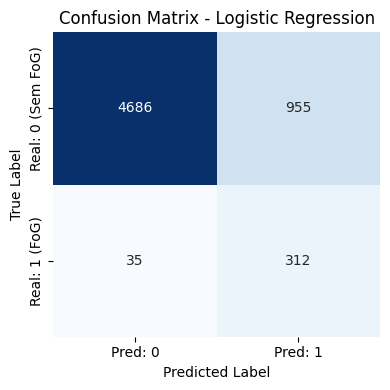


🔍 Random Forest
Acurácia: 96.69%

📊 Resultado: Random Forest
----------------------------------------

🔍 Classification Report:


,precision,recall,f1-score,support
0,0.971,0.994,0.983,5641.000
1,0.850,0.522,0.646,347.000
accuracy,0.967,0.967,0.967,0.967
macro avg,0.911,0.758,0.815,5988.000
weighted avg,0.964,0.967,0.963,5988.000



🧮 Confusion Matrix:


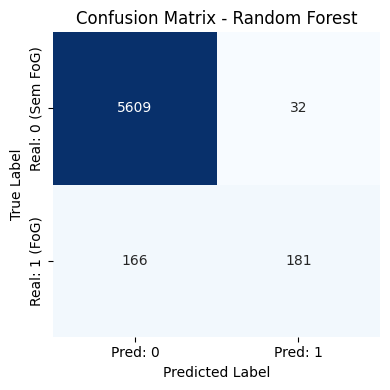


🔍 Gradient Boosting
Acurácia: 95.47%

📊 Resultado: Gradient Boosting
----------------------------------------

🔍 Classification Report:


,precision,recall,f1-score,support
0,0.960,0.993,0.976,5641.000
1,0.744,0.334,0.461,347.000
accuracy,0.955,0.955,0.955,0.955
macro avg,0.852,0.664,0.719,5988.000
weighted avg,0.948,0.955,0.947,5988.000



🧮 Confusion Matrix:


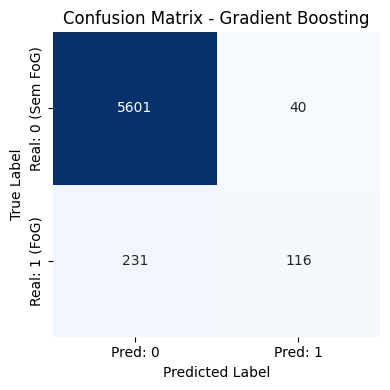

In [10]:
# 1. Split com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 2. Escalando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier()
}

# 4. Treinamento e avaliação
for name, model in models.items():
    print(f"\n🔍 {name}")
    
    # Usa dados escalados apenas onde faz sentido
    if "Logistic" in name:
        model.fit(X_train_scaled, y_train)
        do_test(model, X_test_scaled, y_test)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        do_test(model, X_test, y_test)
        y_pred = model.predict(X_test)
    
    print_model_report(model, X_test_scaled if "Logistic" in name else X_test, y_test, y_pred, name)

# Avaliação de Modelos de Classificação - Freezing of Gait (FoG)

## Etapas Realizadas

### 1. Carregamento do Dataset
Foram utilizados os dados do conjunto **Daphnet Freezing of Gait**, contendo sinais de aceleração de sensores posicionados em pacientes com Parkinson. Os dados brutos foram carregados dos arquivos `.txt` com colunas correspondentes ao tempo, 9 canais de aceleração e rótulos (label):

- `0` = fora do experimento
- `1` = sem congelamento
- `2` = com congelamento (Freezing of Gait)

### 2. Pré-processamento
Os dados foram segmentados em **janelas deslizantes** de tamanho fixo (128 amostras) com sobreposição (passo de 64). Para cada janela:

- Foram extraídas **features estatísticas** (média, desvio padrão, mínimo e máximo de cada canal)
- A janela foi rotulada como `1` (FoG) se mais de 50% das amostras forem `label=2`, caso contrário `0`

### 3. Divisão de Dados
Os dados foram divididos em treino e teste com `train_test_split` e estratificação para manter a proporção das classes. Como os dados estavam desbalanceados (classe `1` é minoria), foram aplicadas técnicas de compensação (`class_weight='balanced'`).

### 4. Treinamento de Modelos
Foram treinados três modelos de classificação:

- **Logistic Regression** (com `StandardScaler`)
- **Random Forest**
- **Gradient Boosting**

Cada modelo foi avaliado com:
- Acurácia
- Matriz de confusão
- Precision, Recall e F1-score


## Resultados Obtidos

### Logistic Regression
- **Acurácia**: 83.47%
- **Recall classe 1 (FoG)**: 0.899
- **Precision classe 1**: 0.246

**Interpretação:** Modelo muito sensível à classe FoG, detecta quase todos os episódios reais (alto recall), mas comete muitos falsos positivos (baixa precisão). Útil para aplicações onde é preferível errar por excesso.

---

### Random Forest
- **Acurácia**: 96.69%
- **Recall classe 1 (FoG)**: 0.522
- **Precision classe 1**: 0.850

**Interpretação:** Modelo equilibrado. Detecta metade dos episódios com alta precisão. Bom para aplicações práticas onde queremos boa detecção com poucos alarmes falsos.

---

### Gradient Boosting
- **Acurácia**: 95.47%
- **Recall classe 1 (FoG)**: 0.334
- **Precision classe 1**: 0.744

**Interpretação:** Modelo conservador. Detecta poucos episódios, mas com alta confiança. Útil quando alarmes falsos são muito indesejáveis.


## Comparação

| Modelo              | Recall (FoG) | Precision (FoG) | F1-score (FoG) | Acurácia |
|---------------------|--------------|------------------|----------------|----------|
| Logistic Regression | **0.899**    | 0.246            | 0.387          | 83.47%   |
| Random Forest       | 0.522        | **0.850**        | **0.646**      | **96.69%** |
| Gradient Boosting   | 0.334        | 0.744            | 0.461          | 95.47%   |

## Conclusão

O modelo Random Forest apresentou o melhor equilíbrio entre sensibilidade (recall) e precisão, sendo o mais adequado para aplicações práticas em detecção de Freezing of Gait com sensores. 

Modelos como Logistic Regression são úteis quando se quer garantir que nenhum episódio passe despercebido, mesmo com maior taxa de falsos positivos. 

Gradient Boosting pode ser útil em contextos onde alertas falsos devem ser evitados ao máximo.


## Próximos Passos

- Aplicar técnicas de balanceamento como SMOTE ou ADASYN
- Avaliar curvas ROC e PR
- Gerar dados sintéticos com GANs e comparar desempenho
- Visualizar janelas classificadas incorretamente para entender erros